# General Practice Workforce

In [15]:
# this is a bit of a hack to get relative imports
# to work as if these notebooks were in a package
# change cwd to project root if 'notebooks' in PATH
from os import chdir
from pathlib import Path

if "notebooks" in str(Path.cwd()):
    chdir("..")


import src.constants as constants
from src.schemas import DataCatalog
from src.various_methods import (
    PlotCounter,
    )
import yaml


# Importing SNEE styles
from sneeifstyles import mpl_style
mpl_style()

In [16]:
NOTEBOOK_ALIAS =  "WORKFORCE"
WORKFORCE_CATALOG_ENTRY_NAME = "General Practice workforce"
plot_counter = PlotCounter(name=NOTEBOOK_ALIAS)
# load data catalog
catalog = DataCatalog.load_from_yaml()


# Mapping Clinical staff


- Appointments are recorded as `{'GP','Practice staff','Unknown'}`
- We need to find the real staff FTE for each of these categories
- So that the appointments can be mapped to a staff type based on the current split of FTE
- Staff type determines appointment length, mode and propensity to attend.
- 'Unknown' staff type will be split proportionally between `GP` and `Practice Staff`

In [17]:
workforce_entry =  catalog.get_catalog_entry_by_name("General Practice workforce")
workforce_df = workforce_entry.load()

In [18]:
# select only SNEE
non_gp_staff_mix = workforce_df.loc[
    (workforce_df["SUB_ICB_CODE"].isin(constants.SUB_ICB_CODES.keys()))]

# set staff group to 'Advanced Nurse Practitioners' if 'STAFF_ROLE' is 'Advanced Nurse Practitioners' in non_gp_staff_mix
non_gp_staff_mix.loc[non_gp_staff_mix['STAFF_ROLE'] == 'Advanced Nurse Practitioners', 'STAFF_GROUP'] = 'Advanced Nurse Practitioners'

# fix typo in 'Admin/Non-clinical' in 'STAFF_GROUP'
non_gp_staff_mix = non_gp_staff_mix.replace({'Admin/Non-clinical':'Admin/Non-Clinical'})

# groupby sum to get FTE
staff_fte =  non_gp_staff_mix.groupby(['SUB_ICB_CODE', 'STAFF_GROUP'])[['FTE']].sum().reset_index()
staff_fte.head(20)

,SUB_ICB_CODE,STAFF_GROUP,FTE
0,06L,Admin/Non-Clinical,569.526796
1,06L,Advanced Nurse Practitioners,44.813333
2,06L,Direct Patient Care,196.760585
3,06L,GP,223.145140
4,06L,Nurses,90.021525
5,06T,Admin/Non-Clinical,480.339551
6,06T,Advanced Nurse Practitioners,50.696543
7,06T,Direct Patient Care,109.227660
8,06T,GP,176.349687
9,06T,Nurses,87.451909


### Plotting staff FTE

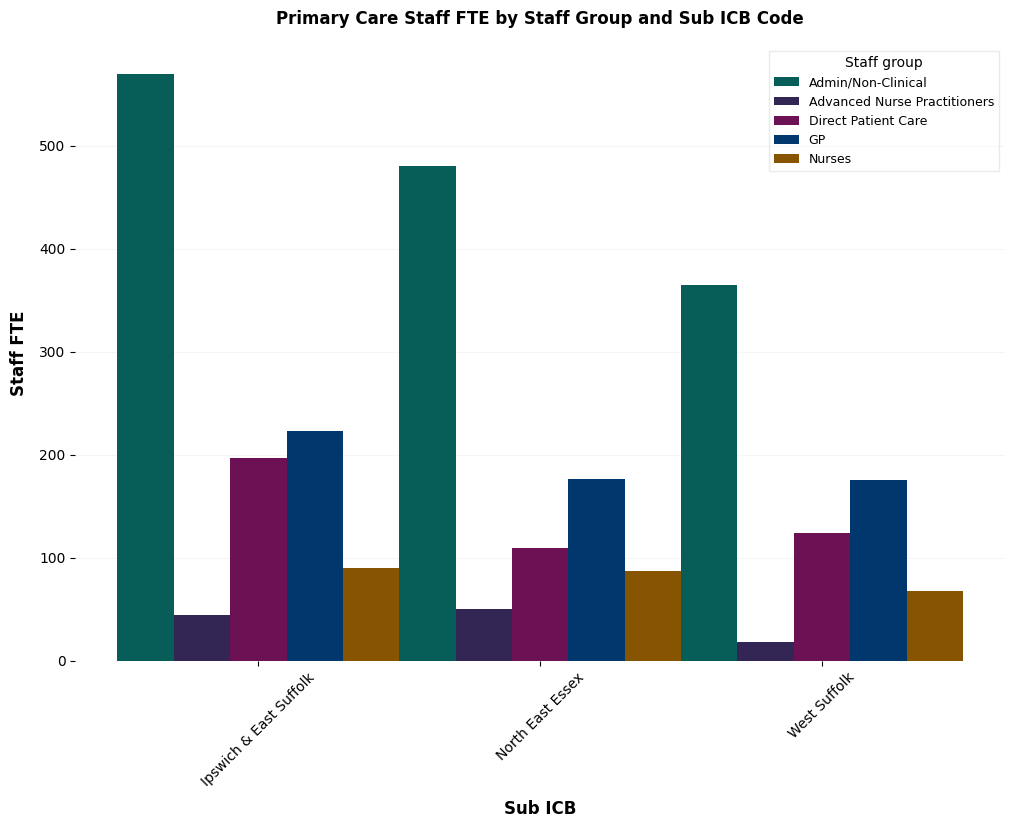

In [19]:
import numpy as np

import matplotlib.pyplot as plt

# Create a bar plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

# Define the width of each bar
bar_width = 0.2



# Get the unique SUB_ICB_CODEs and their positions
sub_icb_codes = staff_fte['SUB_ICB_CODE'].unique()
positions = np.arange(len(sub_icb_codes))

# Plot each staff group with a different color
for i, staff_group in enumerate(staff_fte['STAFF_GROUP'].unique()):
    subset = staff_fte[staff_fte['STAFF_GROUP'] == staff_group]
    ax.bar(positions + i * bar_width, subset['FTE'], bar_width, label=staff_group)

# Add title and labels
ax.set_title('Primary Care Staff FTE by Staff Group and Sub ICB Code')
ax.set_xlabel('Sub ICB')
ax.set_ylabel('Staff FTE')

# Set the x-ticks to be in the middle of the grouped bars
ax.set_xticks(positions + bar_width * (len(staff_fte['STAFF_GROUP'].unique()) - 1) / 2)
ax.set_xticklabels([constants.SUB_ICB_CODES.get(code) for code in sub_icb_codes])

# Rotate x labels for better readability
plt.xticks(rotation=45)

# Display the legend
ax.legend(title='Staff group', loc='best')

# Save the plot
plt.savefig(f"{plot_counter.plot_name}.png")

# Display the plot
plt.show()


### Calculate total non-GP and non-Admin staff FTE for each ICB

In [20]:
# drop 'GP' and 'Admin/Non-Clinical' staff groups
non_gp_clinical_staff_fte = staff_fte.loc[~staff_fte['STAFF_GROUP'].isin(['GP', 'Admin/Non-Clinical'])]

# sum of FTE for each SUB_ICB_CODE
staff_fte_sum = non_gp_clinical_staff_fte.groupby('SUB_ICB_CODE')['FTE'].sum()

display(staff_fte_sum)

SUB_ICB_CODE
06L    331.595443
06T    247.376112
07K    208.701021
Name: FTE, dtype: float64

In [21]:
# calculate non-gp clinical staff mix
non_gp_clinical_staff_mix = (
    non_gp_clinical_staff_fte
    .merge(staff_fte_sum, on='SUB_ICB_CODE', suffixes=('', '_sum'))
    .assign(fte_percent=lambda x: x['FTE'] / x['FTE_sum'])
    .drop(columns=['FTE_sum','FTE'])
    .round(3)
    )
non_gp_clinical_staff_mix.head(20)

,SUB_ICB_CODE,STAFF_GROUP,fte_percent
0,06L,Advanced Nurse Practitioners,0.135
1,06L,Direct Patient Care,0.593
2,06L,Nurses,0.271
3,06T,Advanced Nurse Practitioners,0.205
4,06T,Direct Patient Care,0.442
5,06T,Nurses,0.354
6,07K,Advanced Nurse Practitioners,0.086
7,07K,Direct Patient Care,0.592
8,07K,Nurses,0.322


### Non-GP Staff mix plot

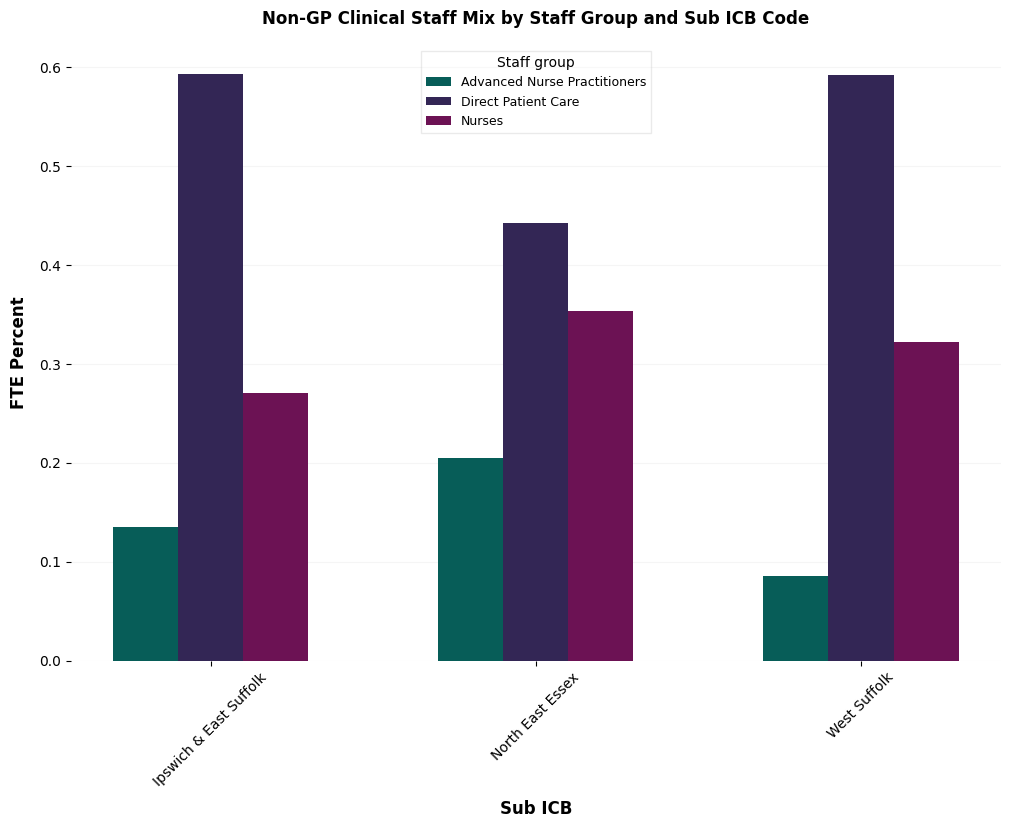

In [22]:
# Create a bar plot for non-GP clinical staff mix using matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

# Define the width of each bar
bar_width = 0.2

# Get the unique SUB_ICB_CODEs and their positions
sub_icb_codes = non_gp_clinical_staff_mix['SUB_ICB_CODE'].unique()
positions = np.arange(len(sub_icb_codes))

# Plot each staff group with a different color
for i, staff_group in enumerate(non_gp_clinical_staff_mix['STAFF_GROUP'].unique()):
    subset = non_gp_clinical_staff_mix[non_gp_clinical_staff_mix['STAFF_GROUP'] == staff_group]
    ax.bar(positions + i * bar_width, subset['fte_percent'], bar_width, label=staff_group)

# Add title and labels
ax.set_title('Non-GP Clinical Staff Mix by Staff Group and Sub ICB Code')
ax.set_xlabel('Sub ICB')
ax.set_ylabel('FTE Percent')

# Set the x-ticks to be in the middle of the grouped bars
ax.set_xticks(positions + bar_width * (len(non_gp_clinical_staff_mix['STAFF_GROUP'].unique()) - 1) / 2)
ax.set_xticklabels([constants.SUB_ICB_CODES.get(code) for code in sub_icb_codes])

# Rotate x labels for better readability
plt.xticks(rotation=45)

# Display the legend
ax.legend(title='Staff group', loc='best')

# Save the plot
plt.savefig(f"{plot_counter.plot_name}_non_gp_clinical_staff_mix.png")

# Display the plot
plt.show()

## Output: 
#### 2024 FTE by staff group

In [23]:
staff_fte_dict = {}
for sub_icb_code in staff_fte['SUB_ICB_CODE'].unique():
    staff_fte_dict[sub_icb_code] = staff_fte.loc[staff_fte['SUB_ICB_CODE'] == sub_icb_code].round(1).set_index('STAFF_GROUP')['FTE'].to_dict()
    # save the non_gp_clinical_staff_mix to a yaml
with open(constants.WORKFORCE_CURRENT_STAFF_FTE, "w") as f:
    yaml.dump(staff_fte_dict, f)


#### Non-GP staff mix

In [24]:
output_non_gp_dict = {}
for sub_icb_code in non_gp_clinical_staff_mix['SUB_ICB_CODE'].unique():
    output_non_gp_dict[sub_icb_code] = non_gp_clinical_staff_mix.loc[non_gp_clinical_staff_mix['SUB_ICB_CODE'] == sub_icb_code].set_index('STAFF_GROUP')['fte_percent'].to_dict()
# save to yaml in outputs
with open(constants.WORKFORCE_NON_GP_CLINICAL_STAFF_SPLIT_FILENAME, "w") as f:
    yaml.dump(output_non_gp_dict, f)

### Admin staff FTE per clinician

In [25]:
staff_fte_admin_calc_df = staff_fte.assign(admin=lambda df: df['STAFF_GROUP'].str.contains('Admin'))
staff_fte_admin_calc_df = staff_fte_admin_calc_df.groupby(['SUB_ICB_CODE', 'admin'])[['FTE']].sum()['FTE'] / staff_fte_admin_calc_df.groupby('SUB_ICB_CODE').sum(numeric_only=True)['FTE']
staff_fte_admin_calc_df = staff_fte_admin_calc_df.to_frame().reset_index()
staff_fte_requirement_dict = staff_fte_admin_calc_df.loc[staff_fte_admin_calc_df['admin'] == True].drop(columns='admin').set_index('SUB_ICB_CODE').round(3).to_dict()['FTE']
# save to yaml in outputs
with open(constants.WORKFORCE_ADMIN_REQUIREMENTS_FILENAME, "w") as f:
    yaml.dump(staff_fte_requirement_dict, f)